# Estimating the Alfven Mach Number ($M_A$)
## Method 1: Sampling radial $V_{CME}$ from the EUV images and $V_A$ from the MAS model

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
import sunpy
sunpy.log.setLevel(logging.WARNING) # Set SunPy's logger to only show WARNING or above

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.dates
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.coordinates import SphericalScreen
from sunpy.sun import constants as const
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import ConnectionPatch
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, PercentileInterval
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is stored
data_dir = '/home/mnedal/data'

### Load SUVI images

In [3]:
suvi_map_objects  = myfuncs.load_suvi(data_dir=data_dir,
                                      start='2024-05-14T17:00:00',
                                      end='2024-05-14T18:00:00',
                                      channel=195)                  # load SUVI data files
clean_suvi_maps   = myfuncs.remove_redundant_maps(suvi_map_objects) # remove redundant images
suvi_seq_runratio = myfuncs.apply_runratio(clean_suvi_maps)         # make running ratio maps

for m in suvi_seq_runratio:
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)  # normalize the intensity range

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


Applying running ratio ...:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 21/22 [00:00<00:00, 45.79it/s]


### Preview map

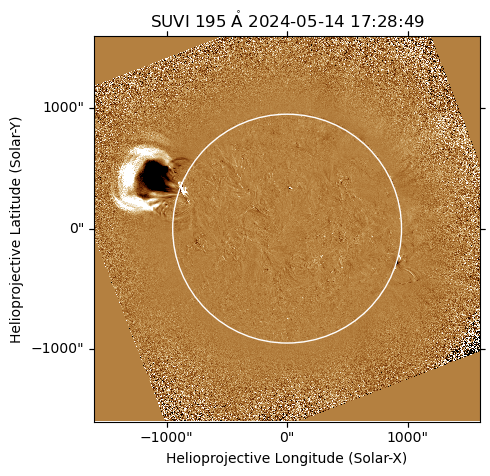

In [4]:
m = suvi_seq_runratio[6]

fig = plt.figure(figsize=[5,5])
ax  = fig.add_subplot(projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
fig.tight_layout()
plt.show()

### Show the radial slits

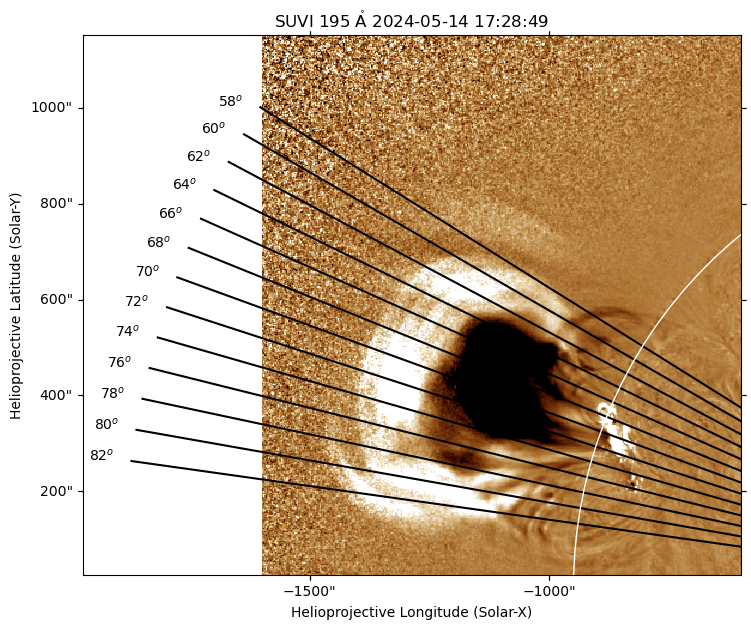

In [5]:
centered_list = myfuncs.generate_centered_list(160, 2, 6)

fig = plt.figure(figsize=[10,7])
ax  = fig.add_subplot(projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

for value in centered_list:
    line = myfuncs.plot_line(angle_deg=value, length=1890, map_obj=m)
    ax.plot_coord(line, color='black')
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax.text(end_point_pixel.x.value - 25, end_point_pixel.y.value + 5, f'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

ax.set_xlim(left=-150, right=400)
ax.set_ylim(bottom=650, top=1100)
fig.tight_layout()
plt.show()

### Load the pre-estimated radial CME speeds along the slits

In [6]:
suvi_filenames = sorted(glob.glob(f'{data_dir}/jplots/suvi/clicking/*.csv'))
print(len(suvi_filenames), *suvi_filenames, sep='\n')

13
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_148.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_150.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_152.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_154.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_156.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_158.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_160.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_162.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_164.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_166.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_168.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_170.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_172.csv


In [7]:
# print the updated filnames after converting the geometric angles to position angles
updated_filenames = [
    f'{path.rsplit("_", 1)[0]}_{int(path.rsplit("_", 1)[1].replace(".csv", "")) - 90}.csv'
    for path in suvi_filenames
]

print(*updated_filenames, sep='\n')

/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_58.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_60.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_62.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_64.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_66.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_68.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_70.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_72.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_74.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_76.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_78.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_80.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_82.csv


In [8]:
# get the radius of the Sun in km
sun_radius_km = const.radius.to('km').value

all_speeds_suvi  = []
all_accels_suvi  = []
all_times_suvi   = []
all_dists_suvi   = []

for file in suvi_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_suvi.append(df['speed_km_s'].values)
    all_accels_suvi.append(df['accel_m_s2'].values)
    all_times_suvi.append(df['time'].values)
    all_dists_suvi.append(df['distance_km'].values/sun_radius_km)
    # print(f"Max: {np.nanmax(df['distance_km'].values/sun_radius_km):.2f} Rs")
    # print(f"Min: {np.nanmin(df['distance_km'].values/sun_radius_km):.2f} Rs\n")

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)
combined_array_t = np.concatenate(all_times_suvi)
combined_array_d = np.concatenate(all_dists_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

Start height: 1.17 Rs
End height:  1.92 Rs

Start time: 2024-05-14 17:12:35
End time:  2024-05-14 17:37:02


In [9]:
df.head()

,Unnamed: 0,time,distance,x_err,y_err,x_mean,y_mean,distance_km,distance_diff_km,datetime,time_diff_s,speed_km_s,speed_diff,accel_m_s2
0,0,19857.725537,1300.331516,0.000458,10.956754,19857.725537,1300.331516,9.531440e+05,NaN,2024-05-14 17:24:46.389128+00:00,NaN,NaN,NaN,NaN
1,1,19857.728332,1409.052134,0.000450,8.732082,19857.728332,1409.052134,1.032836e+06,79692.294450,2024-05-14 17:28:47.853300+00:00,241.464172,330.037760,NaN,NaN
2,2,19857.731091,1572.133061,0.000475,8.807252,19857.731091,1572.133061,1.152375e+06,119538.441675,2024-05-14 17:32:46.268682+00:00,238.415382,501.387287,171.349527,718.701646


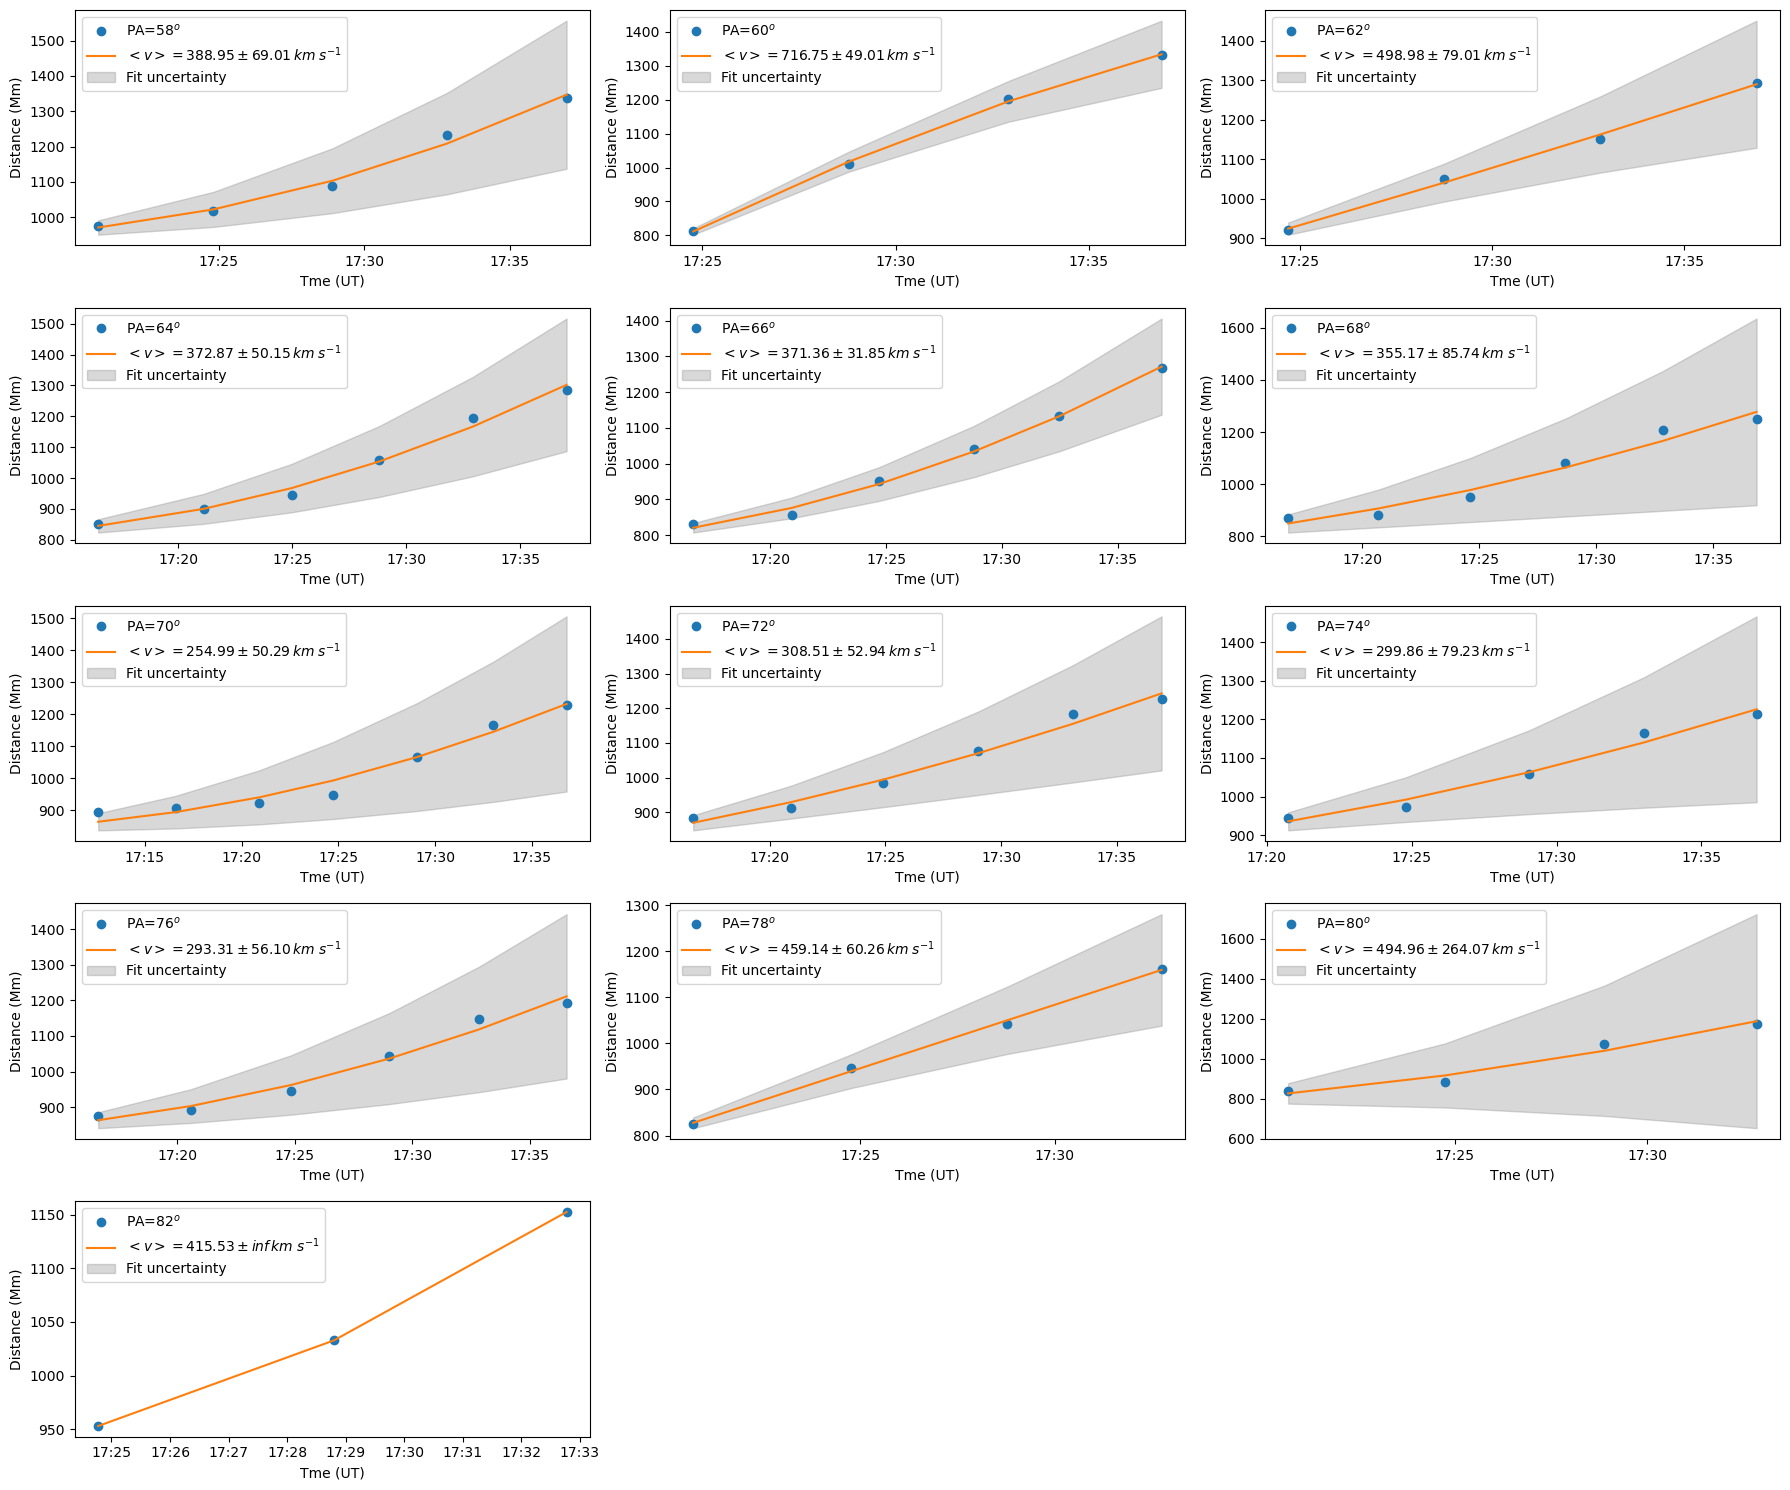

In [10]:
# Initialize an empty list to store results
fit_results_suvi     = []
all_times_suvi       = []
all_speeds_km_s_suvi = []
all_speed_errors     = []
all_accels_m_s2_suvi = []
all_fit_dist_Mm_suvi = []

num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()                                       # Flatten in case of a 2D array of axes

for i, file in enumerate(suvi_filenames):
    df = pd.read_csv(file)
    
    angle = file.split('_')[-1][:-4]
    # rename the angles to be position angles, instead of geometric angles
    PA_value = int(angle) - 90
    
    # calc speed via savgol filter, in km/s
    x    = df['time']
    y    = df['distance_km']
    y_Mm = [(y_km*u.km).to('Mm').value for y_km in y]
    
    # apply the kinematic fit
    # ========================
    time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
    # Convert datetime array to seconds starting from zero
    time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
    
    # Apply the fit to each segment
    fitted, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = myfuncs.fit_kinematics(time, y_Mm, d1=1, d2=2)
    # Calculate upper and lower bounds using parameter errors
    fitted_distance_upper = myfuncs.kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
    fitted_distance_lower = myfuncs.kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)
    
    # Convert units to desired formats
    velocity     *= 1_000         # Convert velocity from Mm/s to km/s
    velocity_err *= 1_000         # Convert velocity from Mm/s to km/s
    v0           *= 1_000         # Convert velocity from Mm/s to km/s
    init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
    a     *= 1_000                # Convert acceleration from Mm/s² to km/s²
    a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²
    
    # Estimate velocities
    t_start = time[0]
    t_end   = time[-1]
    # Minimum velocity (at t_start)
    v_min     = v0 + a*t_start
    v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)
    # Maximum velocity (at t_end)
    v_max     = v0 + a*t_end
    v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)
    v_mean     = np.nanmean(velocity)
    v_mean_err = np.sqrt(np.nansum(velocity_err**2)) / len(velocity)
    # Convert units to desired formats
    a     *= 1_000                # Convert acceleration from km/s² to m/s²
    a_err *= 1_000                # Convert acceleration error from km/s² to m/s²
    acceleration *= 1_000_000     # Convert acceleration from Mm/s² to m/s²
    
    # store all speed and accels. --> Why am I doing this? --> To get the overall distribution of each variable
    all_times_suvi.append(time_array)
    all_speeds_km_s_suvi.append(velocity)
    all_speed_errors.append(velocity_err)
    all_accels_m_s2_suvi.append(acceleration)
    all_fit_dist_Mm_suvi.append(fitted)
    
    # Store results as a dictionary
    fit_results_suvi.append({
        'PA': PA_value,
        's0_Mm': s0,
        'v0_km/s': v0,
        'a_m/s2': a,
        'v_min_km/s': v_min,
        'v_max_km/s': v_max,
        'v_mean_km/s': v_mean,
        'init_pos_err_Mm': init_pos_err,
        'init_vel_err_km/s': init_vel_err,
        'a_err_m/s2': a_err,
        'v_min_err_km/s': v_min_err,
        'v_max_err_km/s': v_max_err,
        'v_mean_err_km/s': v_mean_err
    })
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(x, y_Mm, 'o', label=rf'PA={PA_value}$^o$')
    ax.plot(x, fitted, '-', label=rf'$<v>={v_mean:.2f} \pm {v_mean_err:.2f} \, km \; s^{{-1}}$')
    # Plot error bounds as shaded area
    ax.fill_between(x, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
    ax.set_ylabel('Distance (Mm)')
    ax.set_xlabel('Tme (UT)')
    ax.legend(loc='upper left')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Convert list to DataFrame
fit_df_suvi = pd.DataFrame(fit_results_suvi)
fit_df_suvi = fit_df_suvi.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
# Ensure fit_df stays numeric
fit_df_suvi = fit_df_suvi.astype(float)  # Convert all numeric columns back to floats

fig.tight_layout()
plt.show()

In [11]:
fit_df_suvi.head()

,PA,s0_Mm,v0_km/s,a_m/s2,v_min_km/s,v_max_km/s,v_mean_km/s,init_pos_err_Mm,init_vel_err_km/s,a_err_m/s2,v_min_err_km/s,v_max_err_km/s,v_mean_err_km/s
0,58.0,970.35,159.37,477.24,159.37,620.26,388.95,20.39,100.15,199.04,100.15,216.75,69.01
1,60.0,811.58,917.20,-549.74,917.20,517.30,716.75,9.43,62.76,165.54,62.76,135.80,49.01
2,62.0,924.56,466.69,88.31,466.69,531.30,498.98,15.38,101.41,265.66,101.41,219.23,79.01
3,64.0,845.36,148.52,359.29,148.52,591.63,372.87,21.55,80.11,124.11,80.11,172.76,50.15
4,66.0,820.43,176.78,322.29,176.78,567.52,371.36,13.35,51.08,80.84,51.08,110.52,31.85


In [15]:
all_accels_m_s2_suvi

[array([477.23819698, 477.23819698, 477.23819698, 477.23819698,
        477.23819698]),
 array([-549.74304034, -549.74304034, -549.74304034, -549.74304034]),
 array([88.31121292, 88.31121292, 88.31121292, 88.31121292]),
 array([359.29189838, 359.29189838, 359.29189838, 359.29189838,
        359.29189838, 359.29189838]),
 array([322.29105661, 322.29105661, 322.29105661, 322.29105661,
        322.29105661, 322.29105661]),
 array([222.72302651, 222.72302651, 222.72302651, 222.72302651,
        222.72302651, 222.72302651]),
 array([211.42030145, 211.42030145, 211.42030145, 211.42030145,
        211.42030145, 211.42030145, 211.42030145]),
 array([151.43847311, 151.43847311, 151.43847311, 151.43847311,
        151.43847311, 151.43847311]),
 array([187.41718962, 187.41718962, 187.41718962, 187.41718962,
        187.41718962]),
 array([256.4237806, 256.4237806, 256.4237806, 256.4237806, 256.4237806,
        256.4237806]),
 array([-0.75838042, -0.75838042, -0.75838042, -0.75838042]),
 array([52

In [147]:
# # Sanity check ...
# num_files = len(suvi_filenames)
# cols = 3                                             # Number of columns in the figure
# rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
# bins = 10
# fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
# axes = axes.flatten()  

# for i, (x, y) in enumerate(zip(all_times_suvi, all_fit_dist_Mm_suvi)):
#     ax = axes[i]
#     PA_value = fit_df_suvi['PA'][i]
#     ax.plot(x, y, '--o', label=rf'PA={PA_value}$^o$')
#     ax.set_xlabel('Time (UT)')
#     ax.set_xlabel('Distance (Mm)')
#     ax.legend(loc='upper left')
#     ax.xaxis_date()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Hide unused subplots if `num_files` is not a multiple of `cols`
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

In [148]:
# # Sanity check ...
# num_files = len(suvi_filenames)
# cols = 3                                             # Number of columns in the figure
# rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
# bins = 10
# fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
# axes = axes.flatten()  

# for i, (x, y, err) in enumerate(zip(all_times_suvi, all_speeds_km_s_suvi, all_speed_errors)):
#     ax = axes[i]
#     PA_value = fit_df_suvi['PA'][i]
#     ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={PA_value}$^o$')
#     ax.set_ylabel('Velocity (km/s)')
#     ax.set_xlabel('Tme (UT)')
#     ax.legend(loc='upper left')
#     ax.xaxis_date()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Hide unused subplots if `num_files` is not a multiple of `cols`
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

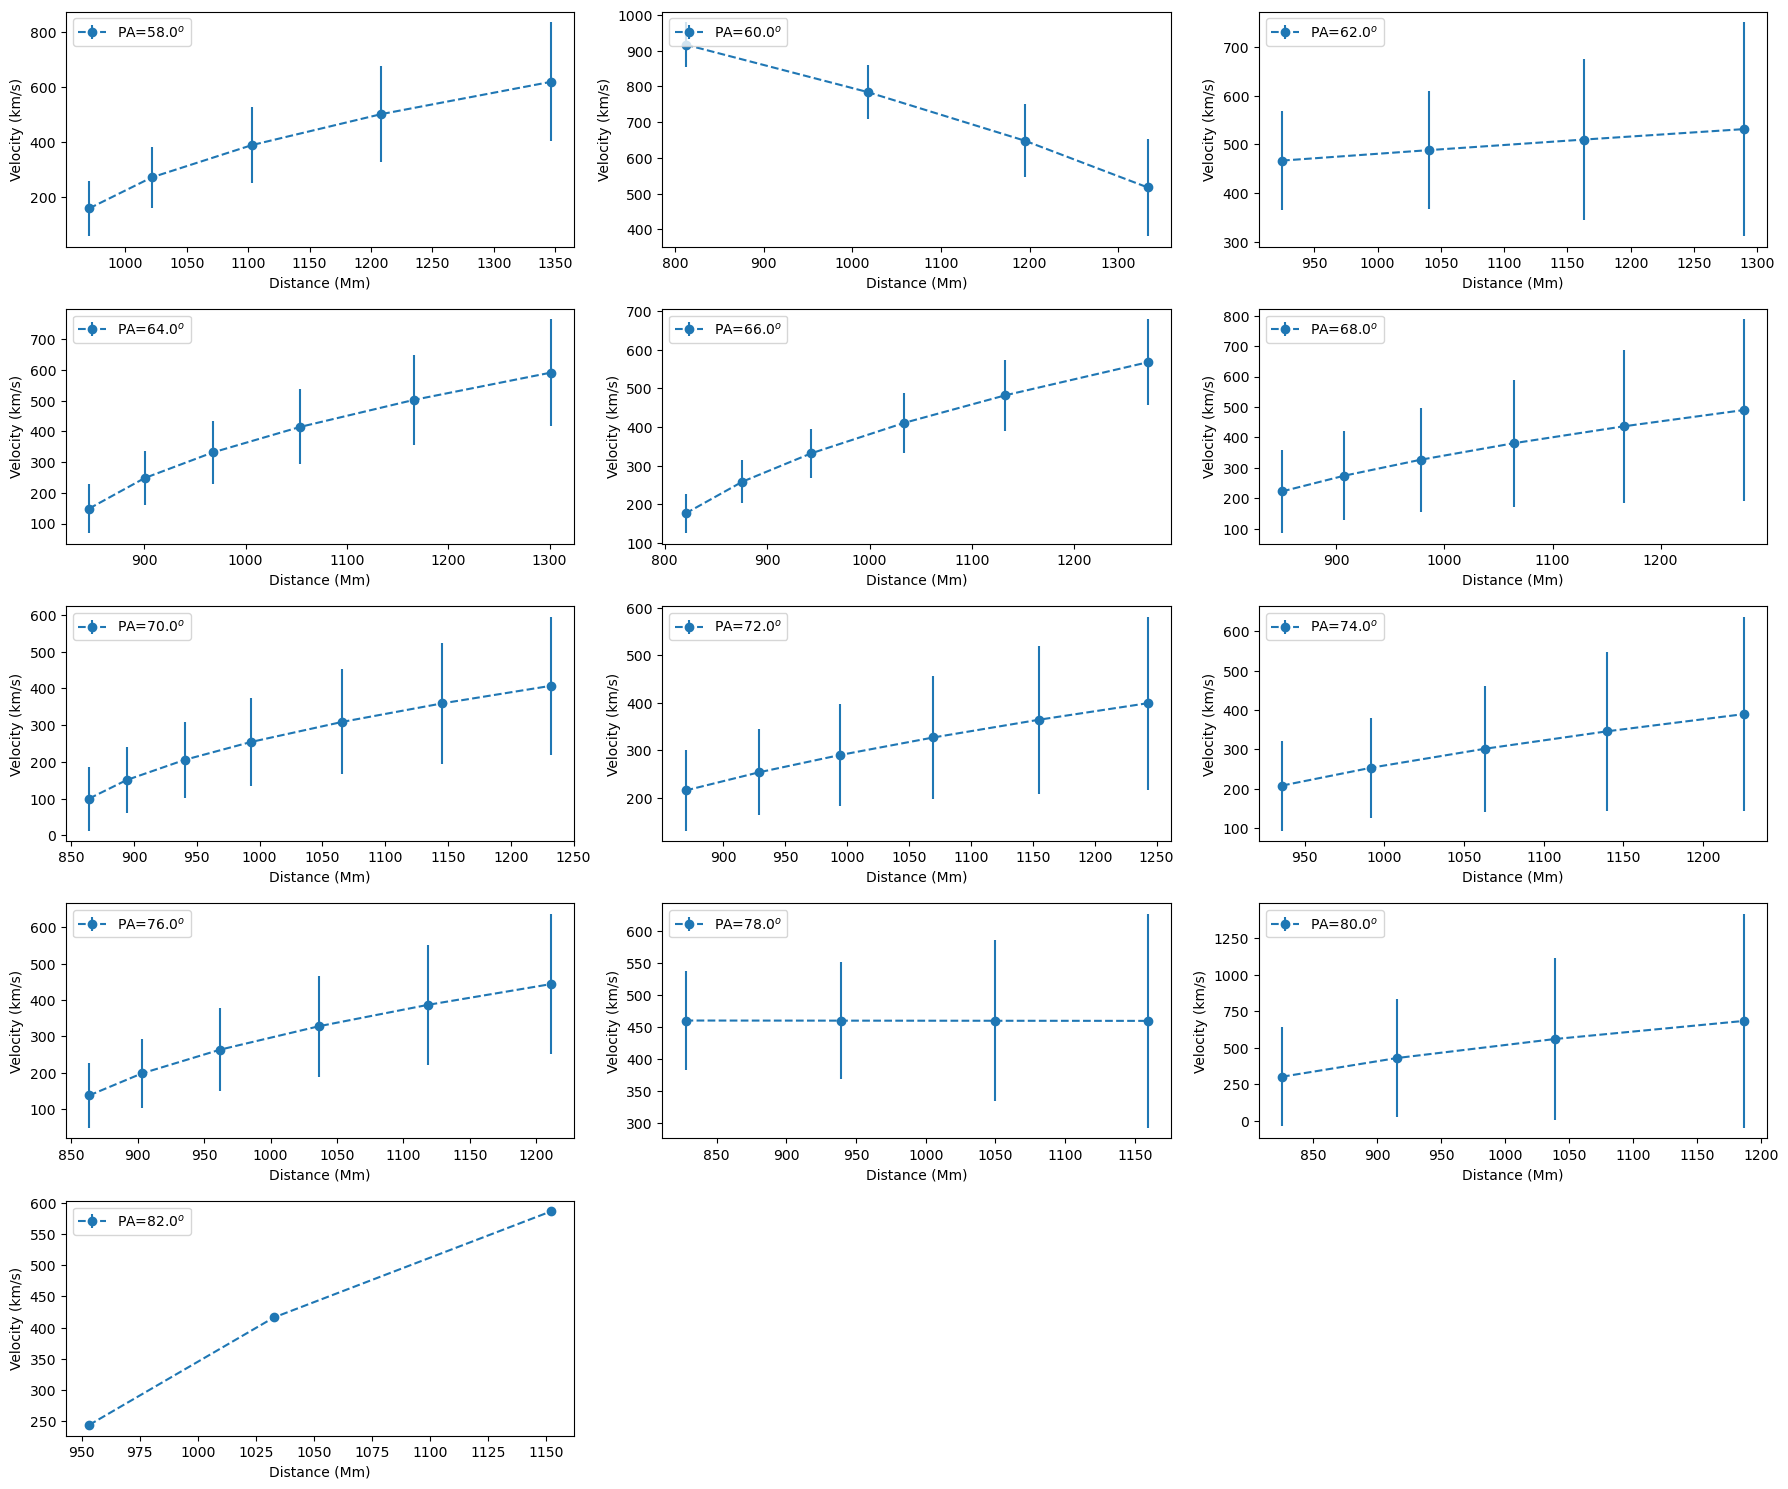

In [141]:
num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  

for i, (x, y, err) in enumerate(zip(all_fit_dist_Mm_suvi, all_speeds_km_s_suvi, all_speed_errors)):
    ax = axes[i]
    PA_value = fit_df_suvi['PA'][i]
    ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={PA_value}$^o$')
    ax.set_ylabel('Velocity (km/s)')
    ax.set_xlabel('Distance (Mm)')
    ax.legend(loc='upper left')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

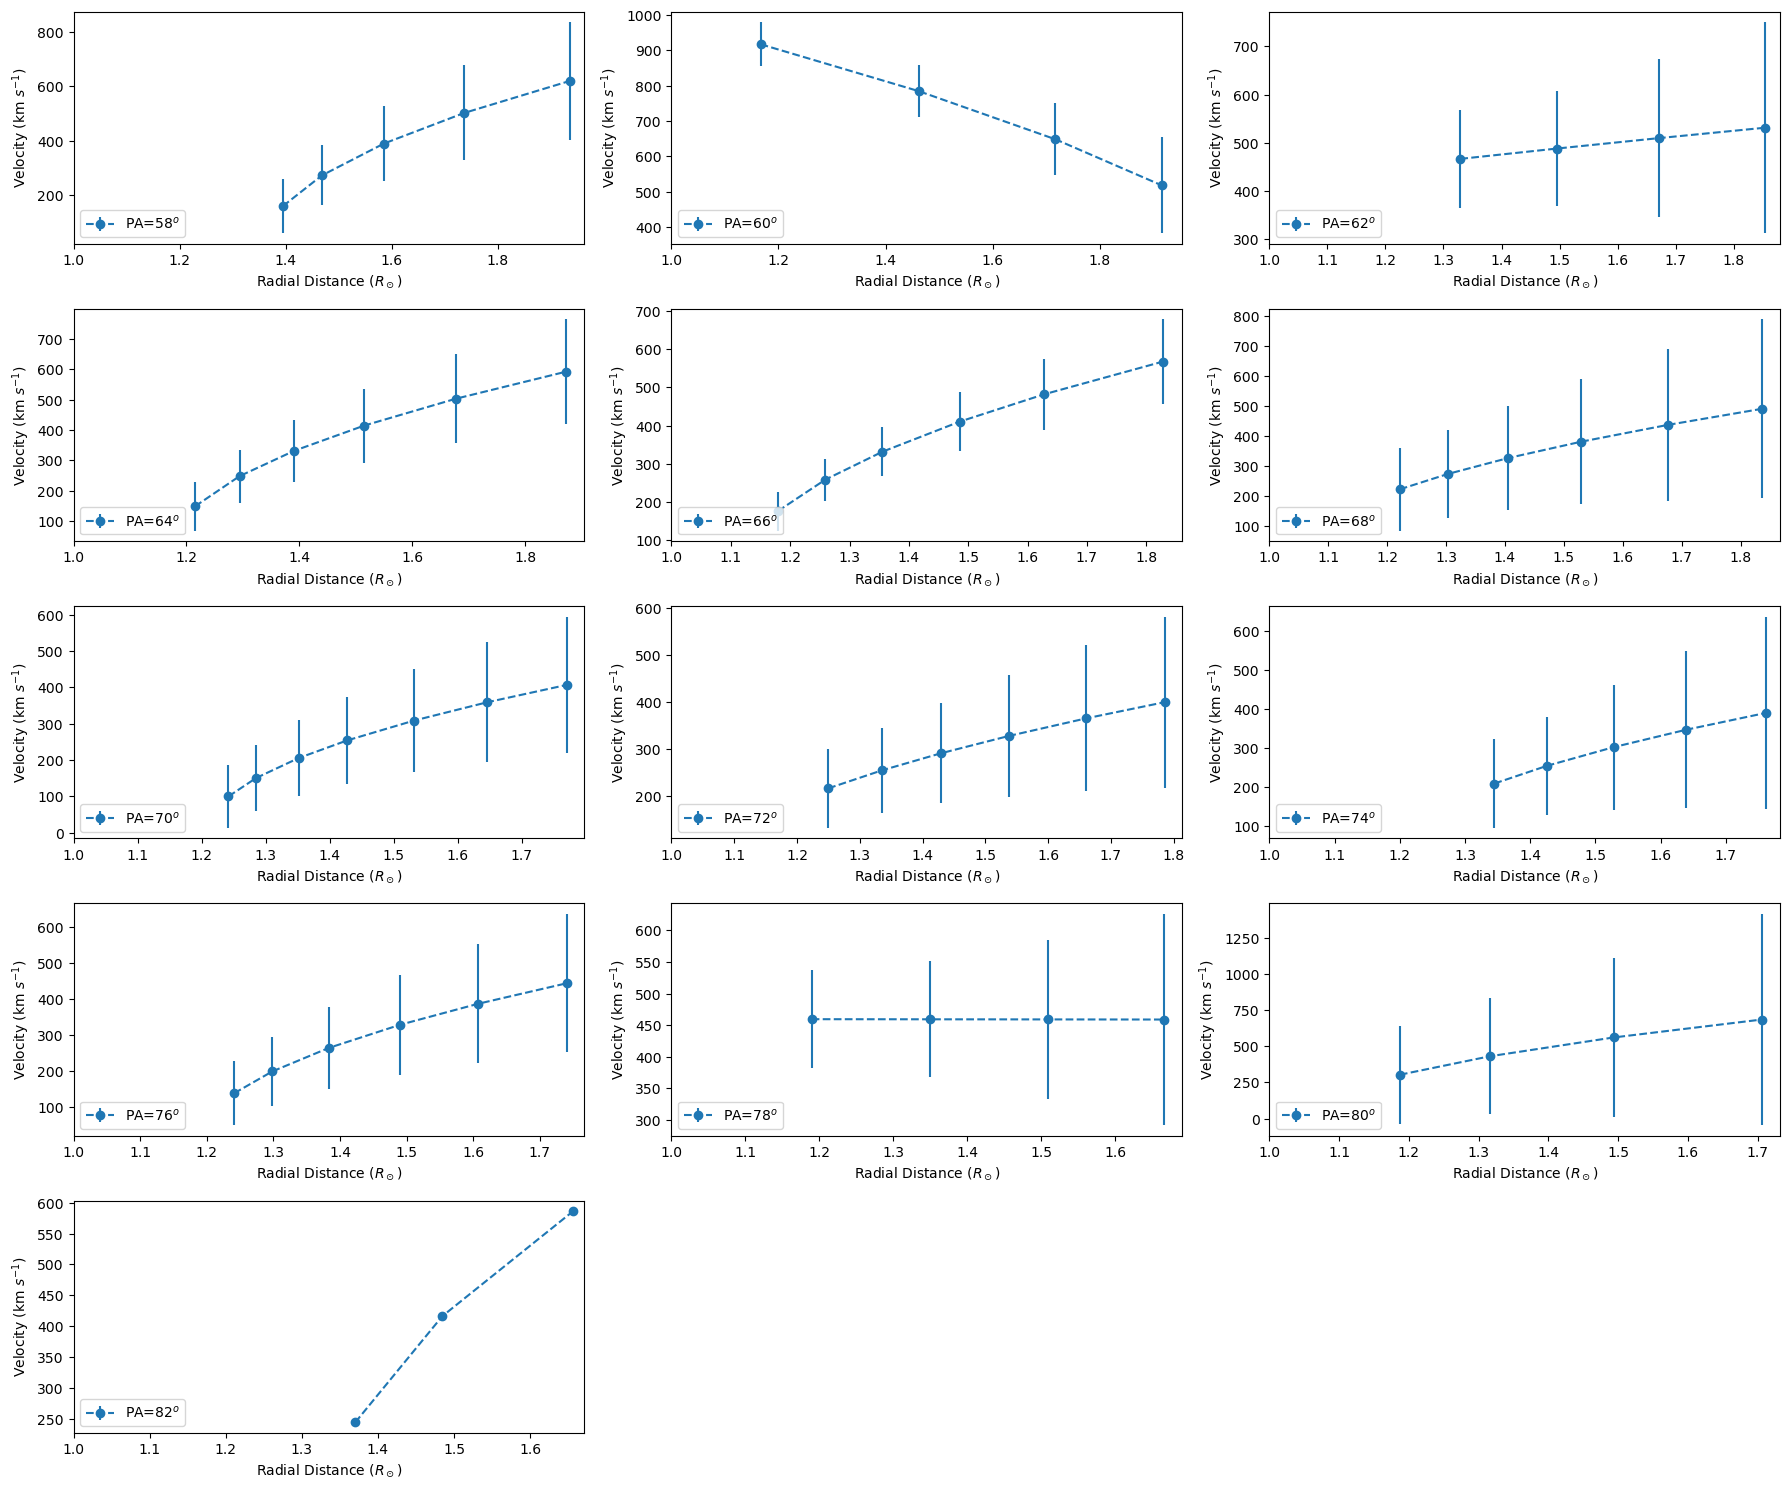

In [253]:
num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  

for i, (x, y, err) in enumerate(zip(all_fit_dist_Mm_suvi, all_speeds_km_s_suvi, all_speed_errors)):
    ax = axes[i]
    x = x*u.Mm.to('solRad')
    PA_value = fit_df_suvi['PA'][i]
    ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={int(PA_value)}$^o$')
    ax.set_ylabel(r'Velocity (km $s^{-1}$)')
    ax.set_xlabel(r'Radial Distance ($R_\odot$)')
    ax.legend(loc='lower left')
    ax.set_xlim(left=1)

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [165]:
max_distance = max(map(np.max, all_fit_dist_Mm_suvi))
min_distance = max(map(np.min, all_fit_dist_Mm_suvi))
print(min_distance, max_distance)

970.3538726439342 1346.8096728106068


In [255]:
1347*u.Mm.to('solRad')

1.936179387667098

### Load PSI-MAS FORWARD maps

In [11]:
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/AIA_20240514_1710_193_512_rfilter.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460559.9840394disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460559.9356944disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460559.9343750disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_PTOT_2460559.9832407disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_TEMP_2460559.9822801disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VPH_2460593.4820486disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VR_2460593.4744676disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VTH_2460593.4788194disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VX_2460593.5005556disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VY_2460593.5060301disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VZ_2460593.5081481disk.sav


In [12]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = myfuncs.get_forward_map(file)
    elif 'DENS' in file:
        dens = myfuncs.get_forward_map(file)

In [14]:
# Calculate the Alfven speed map
mp        = astro_const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
va        = sunpy.map.Map(valf_km_s, dens.meta)

# # Calculate Alfven Mach number
# Ma_arr = vsw.data / va.data
# Ma     = sunpy.map.Map(Ma_arr, vsw.meta)

### Preview maps

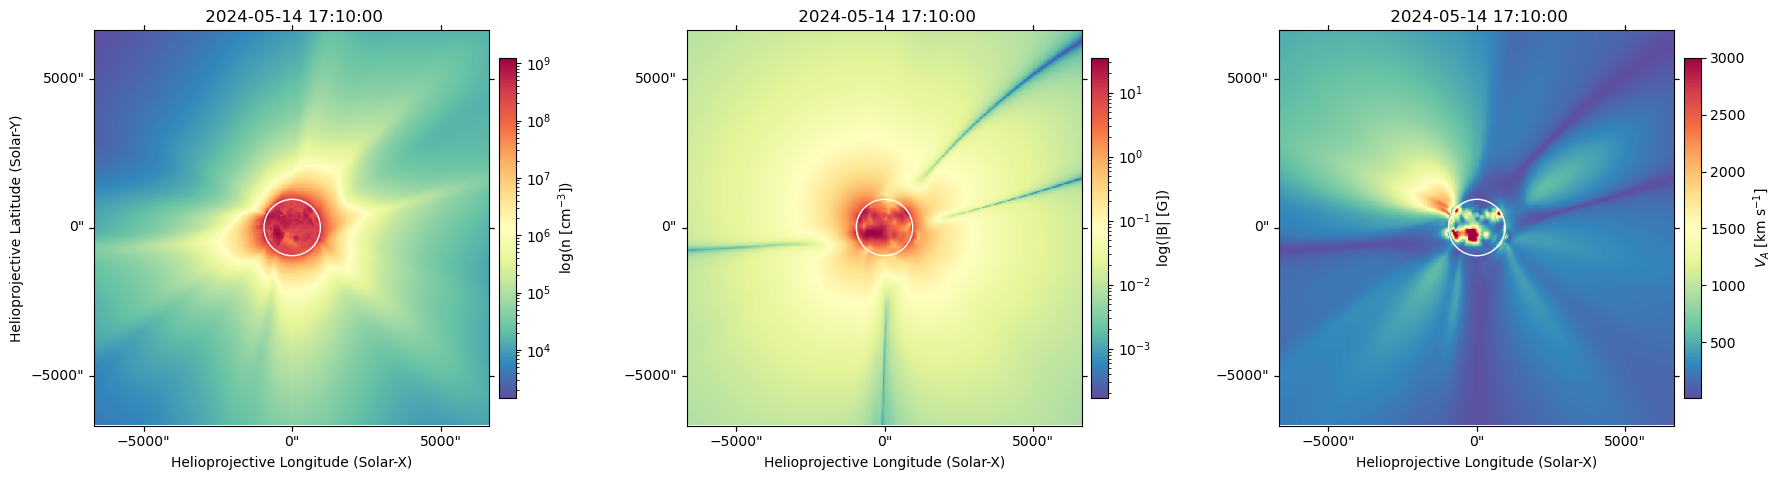

In [19]:
fig = plt.figure(figsize=[18,5])

ax  = fig.add_subplot(131, projection=dens)
img = dens.plot(axes=ax, norm=colors.LogNorm(), cmap='Spectral_r')
dens.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label=r'log(n [cm$^{-3}$])')

ax  = fig.add_subplot(132, projection=bmag)
img = bmag.plot(axes=ax, norm=colors.LogNorm(), cmap='Spectral_r')
bmag.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label='log(|B| [G])')
ax.set_ylabel(' ')

ax  = fig.add_subplot(133, projection=va)
img = va.plot(axes=ax, vmin=1e1, vmax=3e3, cmap='Spectral_r')
va.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label=r'$V_A$ [km s$^{-1}$]')
ax.set_ylabel(' ')

fig.tight_layout()
plt.show()

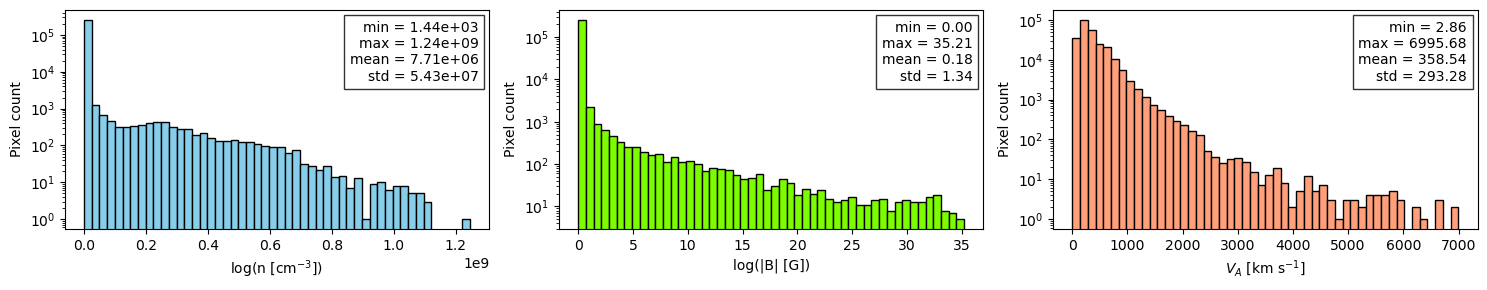

In [275]:
dens_data = dens.data.flatten()
bmag_data = bmag.data.flatten()
va_data   = va.data.flatten()

def make_stats_box(data, var=None):
    if var=='density':
        return (
            rf'min = {np.nanmin(data):.2e}' + '\n' +
            rf'max = {np.nanmax(data):.2e}' + '\n' +
            rf'mean = {np.nanmean(data):.2e}' + '\n' +
            rf'std = {np.nanstd(data):.2e}'
        )
    else:
        return (
            rf'min = {np.nanmin(data):.2f}' + '\n' +
            rf'max = {np.nanmax(data):.2f}' + '\n' +
            rf'mean = {np.nanmean(data):.2f}' + '\n' +
            rf'std = {np.nanstd(data):.2f}'
        )

fig = plt.figure(figsize=[15,3])

# Density histogram
ax  = fig.add_subplot(131)
ax.hist(dens_data, bins=50, log=False, color='skyblue', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel(r'log(n [cm$^{-3}$])')
ax.set_yscale('log')
ax.grid(False)
ax.text(0.975, 0.95, make_stats_box(dens_data, var='density'), transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8))

# Magnetic field histogram
ax  = fig.add_subplot(132)
ax.hist(bmag_data, bins=50, log=False, color='lawngreen', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel('log(|B| [G])')
ax.set_yscale('log')
ax.grid(False)
ax.text(0.975, 0.95, make_stats_box(bmag_data), transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8))

# Alfvén speed histogram
ax  = fig.add_subplot(133)
ax.hist(va_data, bins=50, log=False, color='lightsalmon', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel(r'$V_A$ [km s$^{-1}$]')
ax.set_yscale('log')
ax.grid(False)
ax.text(0.975, 0.95, make_stats_box(va_data), transform=ax.transAxes,
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8))

fig.tight_layout()
plt.show()

In [46]:
print(f'Dimensions of SUVI map: {m.dimensions}\nVA map: {va.dimensions}')
print(f'Difference: {m.dimensions.x/va.dimensions.x}')

Dimensions of SUVI map: PixelPair(x=<Quantity 1280. pix>, y=<Quantity 1280. pix>)
VA map: PixelPair(x=<Quantity 512. pix>, y=<Quantity 512. pix>)
Difference: 2.5


### Trace Alfven speed along the slits

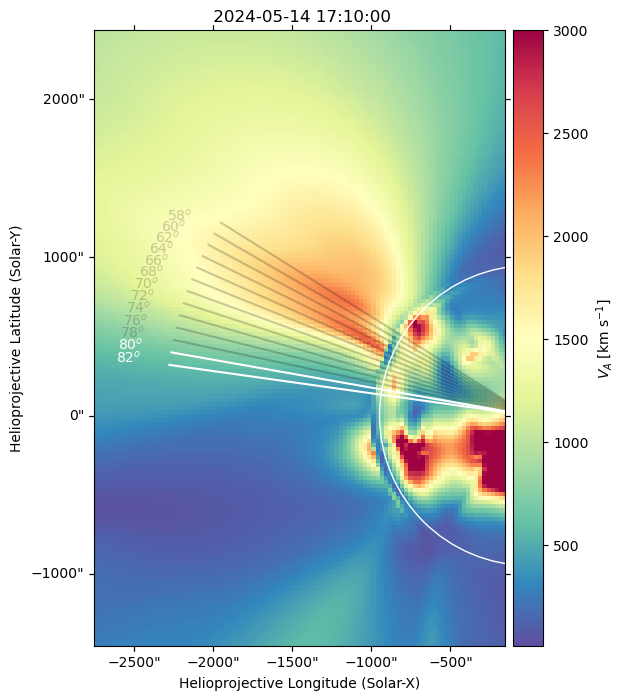

In [366]:
fig = plt.figure(figsize=[10,8])
ax  = fig.add_subplot(projection=va)
img = va.plot(axes=ax, vmin=1e1, vmax=3e3, cmap='Spectral_r')
va.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, pad=0.01, label=r'$V_A$ [km s$^{-1}$]')

sampled_va   = []
sampled_dist = []

for value in centered_list:
    line = myfuncs.plot_line(angle_deg=value, length=2300, map_obj=va)

    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90

    if PA_value==80 or PA_value==82:
        line_color = 'w'
        opacity    = 1
    else:
        line_color = 'black'
        opacity    = 0.2
    ax.plot_coord(line, color=line_color, alpha=opacity)
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = va.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=va.coordinate_frame))
    # Display the number at the end point
    ax.text(end_point_pixel.x.value-10, end_point_pixel.y.value+2, rf'{PA_value}$^o$',
            color=line_color, alpha=opacity, fontsize=10, ha='center', va='center')

    # sample values along slits
    with SphericalScreen(va.observer_coordinate):
        traced_loop_pixelated = sunpy.map.pixelate_coord_path(va, line)
        traced_loop_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
    vals = sunpy.map.sample_at_coords(va, traced_loop_pixelated)
    sampled_va.append(vals)
    sampled_dist.append(traced_loop_distance.to('arcsec'))

ax.set_xlim(left=150, right=250)
ax.set_ylim(bottom=200, top=350)
fig.tight_layout()
plt.show()

## Show SUVI and $V_A$ maps together with the same FOV

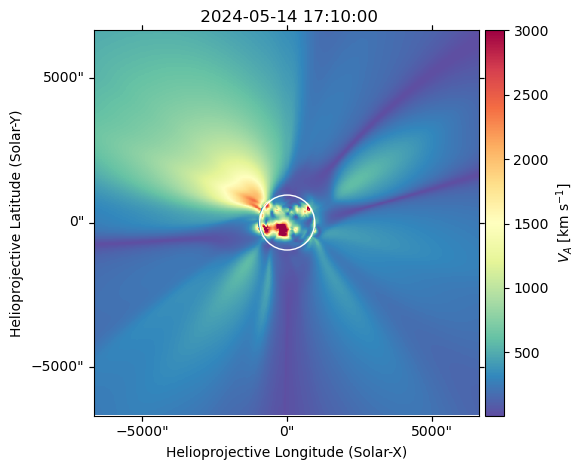

In [425]:
fig = plt.figure()
ax  = fig.add_subplot(projection=va)
img = va.plot(axes=ax, vmin=1e1, vmax=3e3, cmap='Spectral_r')
va.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, pad=0.01, label=r'$V_A$ [km s$^{-1}$]')
fig.tight_layout()
plt.show()

In [405]:
m.coordinate_frame, va.coordinate_frame

(<Helioprojective Frame (obstime=2024-05-14T17:28:49.577, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-05-14T17:28:49.577, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (0.01315982, -2.67057607, 1.51189818e+11)>)>,
 <Helioprojective Frame (obstime=2024-05-14T17:10:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2024-05-14T17:10:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (0., -2.67381635, 1.51212915e+11)>)>)

In [571]:
# define the boundaries
right  = -700
top    = 900
left   = -2000
bottom = -400

# crop SUVI
top_right   = SkyCoord(right*u.arcsec, top*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(left*u.arcsec, bottom*u.arcsec, frame=m.coordinate_frame)
suvi_submap = m.submap(bottom_left, top_right=top_right)

right  = right
top    = top + 200
left   = left - 200
bottom = bottom - 700

# crop VA map
top_right   = SkyCoord(right*u.arcsec, top*u.arcsec, frame=va.coordinate_frame)
bottom_left = SkyCoord(left*u.arcsec, bottom*u.arcsec, frame=va.coordinate_frame)
va_submap   = va.submap(bottom_left, top_right=top_right)

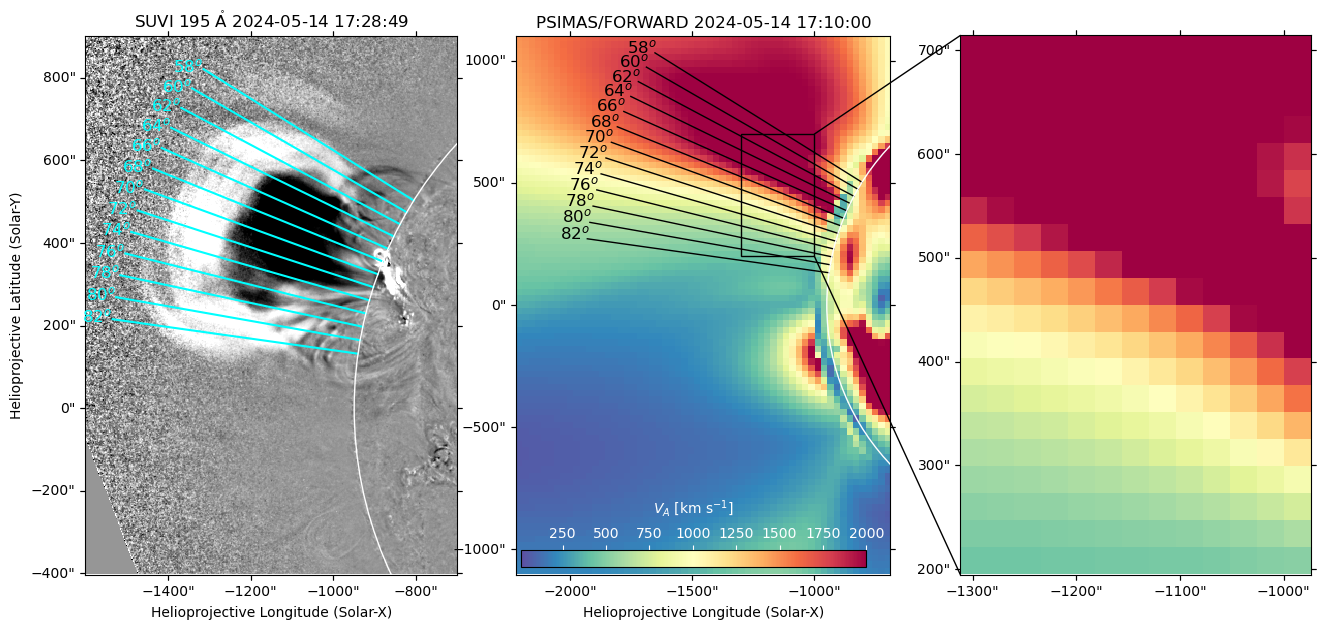

In [634]:
fig = plt.figure(figsize=[16,7])

ax1 = fig.add_subplot(131, projection=suvi_submap)
suvi_submap.plot(axes=ax1)
suvi_submap.draw_limb(axes=ax1)
ax1.grid(False)
for value in centered_list:
    line = myfuncs.plot_line_from_limb(angle_deg=value, length=600, map_obj=suvi_submap)
    ax1.plot_coord(line, color='cyan', linestyle='-')
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = suvi_submap.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=suvi_submap.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax1.text(end_point_pixel.x.value-15, end_point_pixel.y.value+3, f'{PA_value}$^o$',
            color='cyan', fontsize=12, ha='center', va='center')


ax2 = fig.add_subplot(132, projection=va_submap)
img = va_submap.plot(axes=ax2, vmin=1e1, vmax=2e3, cmap='Spectral_r')
va_submap.draw_limb(axes=ax2)
ax2.grid(False)
ax2.set_ylabel(' ')
ax2.set_title(va_submap.meta['obsrvtry'] + ' ' + va_submap.meta['date-obs'][:-4].replace('T',' '))
for value in centered_list:
    line = myfuncs.plot_line_from_limb(angle_deg=value, length=1000, map_obj=va_submap)
    ax2.plot_coord(line, color='k', linestyle='-', linewidth=1)
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = va_submap.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=va_submap.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax2.text(end_point_pixel.x.value-2, end_point_pixel.y.value+1, f'{PA_value}$^o$',
            color='k', fontsize=12, ha='center', va='center')


# draw the rectangle around the region we plan to showcase in the cutout image
left_corner  = SkyCoord(Tx=-1300*u.arcsec, Ty=200*u.arcsec, frame=va_submap.coordinate_frame)
right_corner = SkyCoord(Tx=-1000*u.arcsec, Ty=700*u.arcsec, frame=va_submap.coordinate_frame)
va_submap.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)
# ploy the zoomed-in map
va_small = va_submap.submap(left_corner, top_right=right_corner)
ax3 = fig.add_subplot(133, projection=va_small)
img_small = va_small.plot(axes=ax3, vmin=1e1, vmax=2e3, cmap='Spectral_r')
ax3.grid(False)
ax3.set_xlabel(' ')
ax3.set_ylabel(' ')
ax3.set_title('')

pos = ax2.get_position().get_points()
cax = fig.add_axes([
    pos[0,0], pos[1,1]-0.75, pos[1,0]-pos[0,0]-0.012, 0.025
])
cbar = fig.colorbar(img, cax=cax, orientation='horizontal')
cbar.set_label(r'$V_A$ [km s$^{-1}$]', labelpad=-50, rotation=0, color='w')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.tick_params(axis='x', colors='w')

# add two lines that will connect the two images as well as a colorbar
xpix, ypix = va_submap.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = va_submap.world_to_pixel(SkyCoord(right_corner.Tx, left_corner.Ty, frame=va_submap.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, arrowstyle='-', color='black', lw=1)

ax3.add_artist(con1)
ax3.add_artist(con2)

fig.subplots_adjust(wspace=0.15, hspace=0.1)
fig.savefig(f'{data_dir}/suvi_forward_pixels.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [560]:
suvi_submap.dimensions, va_submap.dimensions

(PixelPair(x=<Quantity 360. pix>, y=<Quantity 522. pix>),
 PixelPair(x=<Quantity 59. pix>, y=<Quantity 85. pix>))

In [564]:
# # define the boundaries
# right  = -700
# top    = 900
# left   = -2000
# bottom = -400

# # crop SUVI
# top_right   = SkyCoord(right*u.arcsec, top*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(left*u.arcsec, bottom*u.arcsec, frame=m.coordinate_frame)
# suvi_submap = m.submap(bottom_left, top_right=top_right)

# # crop VA map
# top_right   = SkyCoord(right*u.arcsec, top*u.arcsec, frame=va.coordinate_frame)
# bottom_left = SkyCoord(left*u.arcsec, bottom*u.arcsec, frame=va.coordinate_frame)
# va_submap   = va.submap(bottom_left, top_right=top_right)



# fig = plt.figure(figsize=[16,7])

# ax1 = fig.add_subplot(131, projection=suvi_submap)
# suvi_submap.plot(axes=ax1)
# suvi_submap.draw_limb(axes=ax1)
# ax1.grid(False)
# for value in centered_list:
#     line = myfuncs.plot_line_from_limb(angle_deg=value, length=600, map_obj=suvi_submap)
#     ax1.plot_coord(line, color='cyan', linestyle='-')
#     # Plot the number at the end of the line
#     # Convert SkyCoord to pixel coordinates for plotting text
#     line_lon, line_lat = line.Tx, line.Ty
#     end_point_pixel = suvi_submap.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=suvi_submap.coordinate_frame))
#     # rename the angles to be position angles, instead of geometric angles
#     PA_value = value - 90
#     # Display the number at the end point
#     ax1.text(end_point_pixel.x.value-15, end_point_pixel.y.value+3, f'{PA_value}$^o$',
#             color='cyan', fontsize=12, ha='center', va='center')


# ax2 = fig.add_subplot(132, projection=va_submap)
# img = va_submap.plot(axes=ax2, vmin=1e1, vmax=3e3, cmap='Spectral_r')
# va_submap.draw_limb(axes=ax2)
# ax2.grid(False)
# ax2.set_ylabel(' ')
# ax2.set_title(va_submap.meta['obsrvtry'] + ' ' + va_submap.meta['date-obs'][:-4].replace('T',' '))
# for value in centered_list:
#     line = myfuncs.plot_line_from_limb(angle_deg=value, length=600, map_obj=va_submap)
#     ax2.plot_coord(line, color='k', linestyle='-', linewidth=1)
#     # Plot the number at the end of the line
#     # Convert SkyCoord to pixel coordinates for plotting text
#     line_lon, line_lat = line.Tx, line.Ty
#     end_point_pixel = va_submap.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=va_submap.coordinate_frame))
#     # rename the angles to be position angles, instead of geometric angles
#     PA_value = value - 90
#     # Display the number at the end point
#     ax2.text(end_point_pixel.x.value-2, end_point_pixel.y.value+1, f'{PA_value}$^o$',
#             color='k', fontsize=12, ha='center', va='center')


# # draw the rectangle around the region we plan to showcase in the cutout image
# left_corner  = SkyCoord(Tx=-1300*u.arcsec, Ty=200*u.arcsec, frame=va_submap.coordinate_frame)
# right_corner = SkyCoord(Tx=-1000*u.arcsec, Ty=700*u.arcsec, frame=va_submap.coordinate_frame)
# va_submap.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)
# # ploy the zoomed-in map
# va_small = va_submap.submap(left_corner, top_right=right_corner)
# ax3 = fig.add_subplot(133, projection=va_small)
# img_small = va_small.plot(axes=ax3, vmin=1e1, vmax=3e3, cmap='Spectral_r')
# ax3.grid(False)
# ax3.set_xlabel(' ')
# ax3.set_ylabel(' ')
# ax3.set_title('')

# # add two lines that will connect the two images as well as a colorbar
# xpix, ypix = va_submap.world_to_pixel(right_corner)
# con1 = ConnectionPatch(
#     (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, 
#     arrowstyle='-', color='black', lw=1)

# xpix, ypix = va_submap.world_to_pixel(SkyCoord(right_corner.Tx, left_corner.Ty, frame=va_submap.coordinate_frame))
# con2 = ConnectionPatch(
#     (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, arrowstyle='-', color='black', lw=1)

# ax3.add_artist(con1)
# ax3.add_artist(con2)

# fig.subplots_adjust(wspace=0.15, hspace=0.1)
# plt.show()

In [385]:
# # Sanity check ...
# fig = plt.figure(figsize=[8,5])
# ax  = fig.add_subplot(111)

# # Choose a colormap with many distinguishable colors
# cmap           = plt.cm.get_cmap('Spectral')
# num_lines      = len(sampled_va)
# colors_list    = cmap(np.linspace(0, 1, num_lines))

# for i in range(len(sampled_va)):
#     # rename the angles to be position angles, instead of geometric angles
#     PA_value = centered_list[i] - 90
#     # convert the distance from Rsun to Mm
#     dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
#     dist_Rs = dist_Rs*u.solRad
#     dist_Mm = dist_Rs.to('Mm')
#     ax.plot(dist_Mm, sampled_va[i],
#             'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

# ax.grid(False)
# ax.legend(loc='upper right', bbox_to_anchor=[1.2,1.02])
# ax.set_xlabel('Radial distance in POS (Mm)')
# ax.set_ylabel(r'$V_A$ [km s$^{-1}$]')
# ax.set_xlim(left=970, right=1347) # min & max dist in SUVI fits
# fig.tight_layout()
# plt.show()

### Fit the sampled Alfven speeds via SavGolay fitting to eliminate the chainsaw pattern

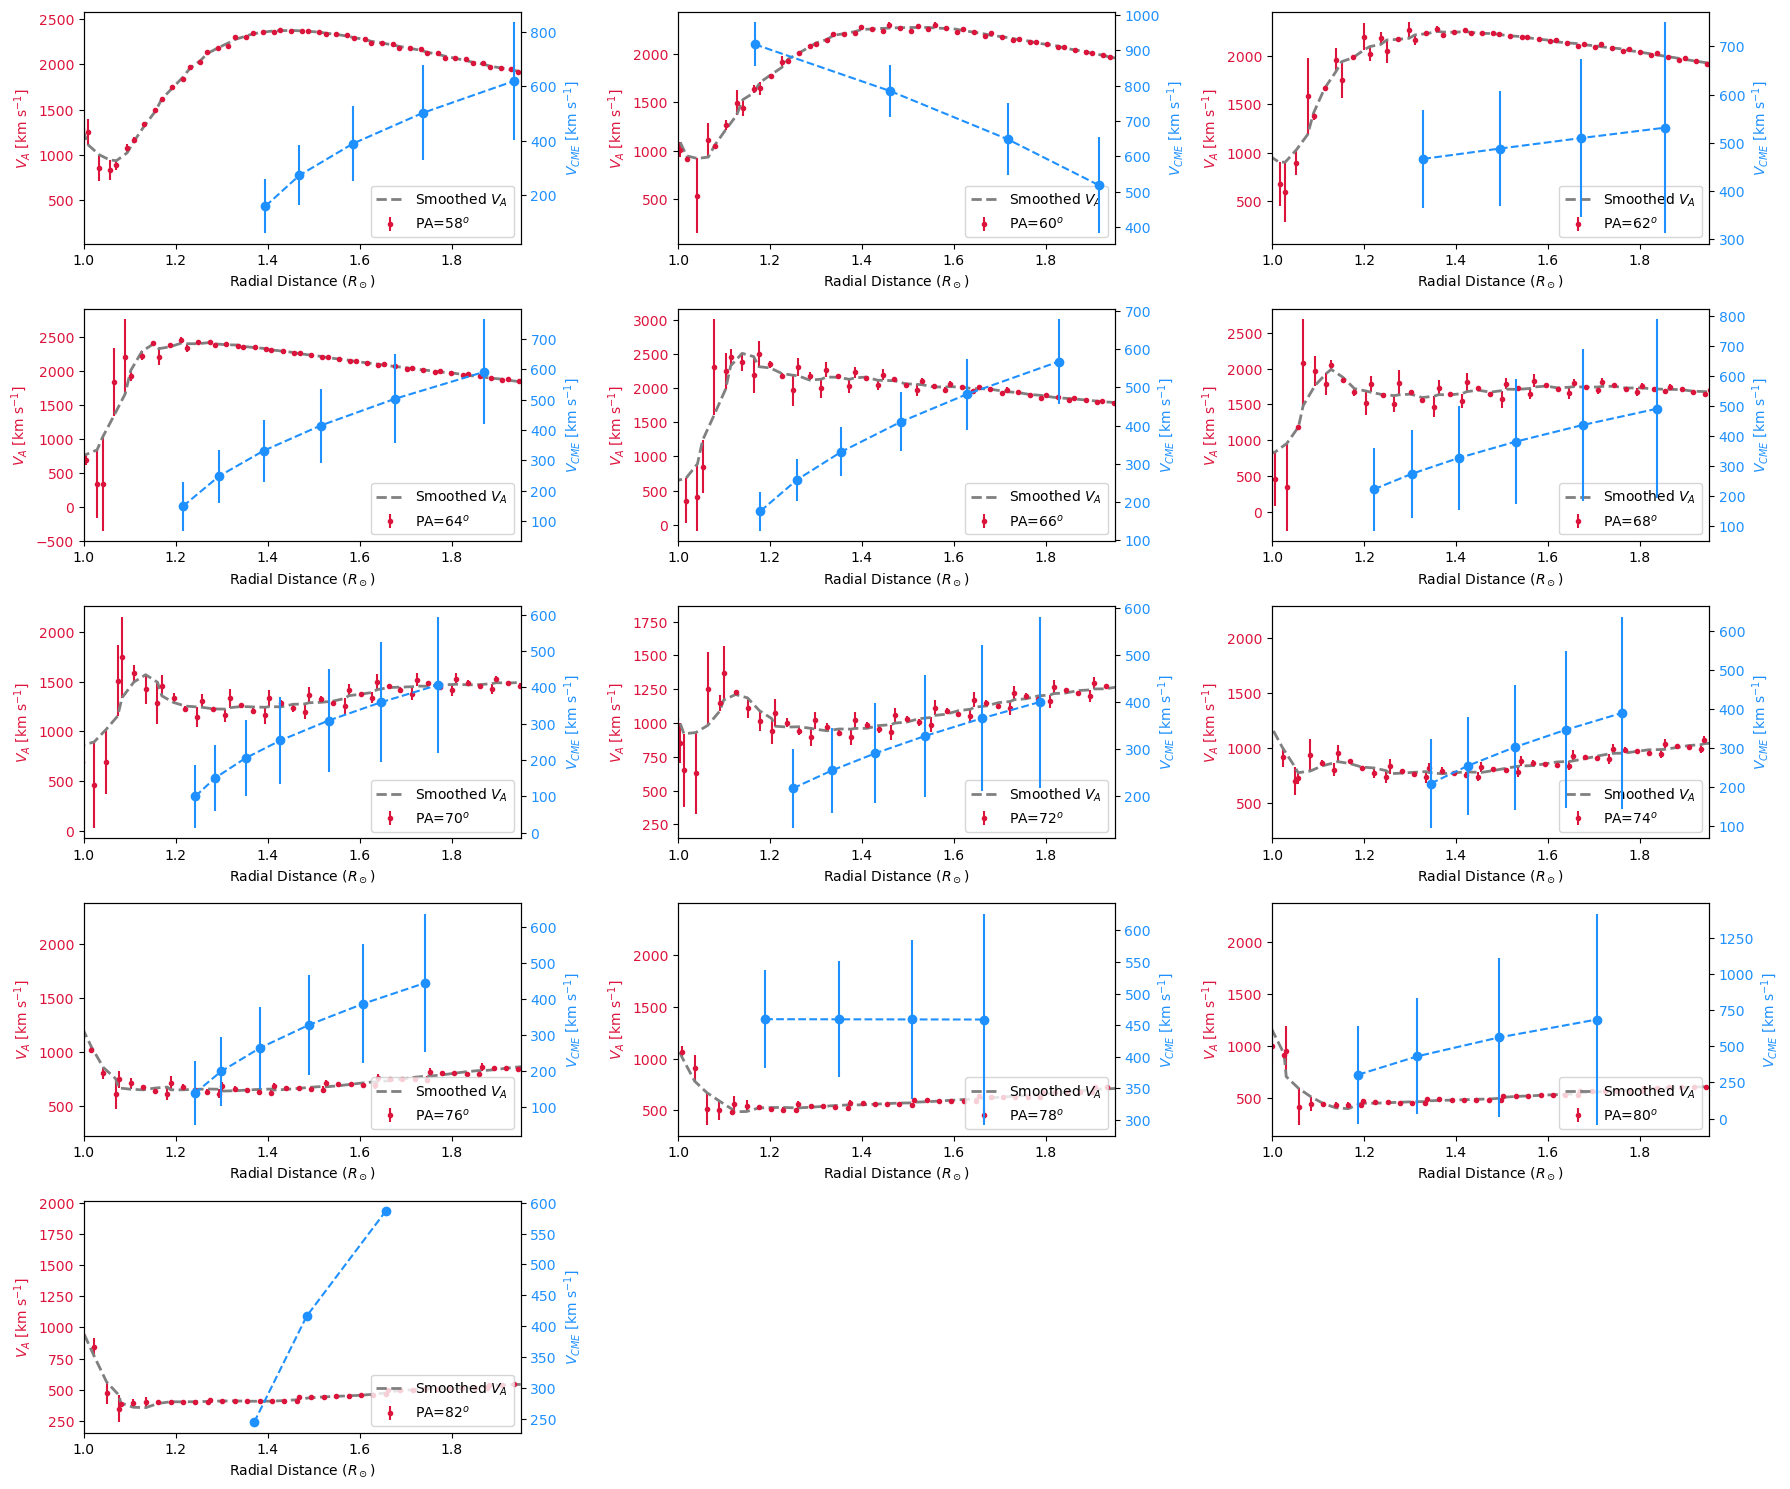

In [565]:
num_files = len(centered_list)
cols = 3
rows = (num_files // cols) + (num_files % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))
axes = axes.flatten()

dist_VA_Rs   = []
smoothed_VA  = []
dist_SUVI_Rs = []
speeds_SUVI  = []

for i in range(len(centered_list)):
    ax = axes[i]
    PA_value = centered_list[i] - 90
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad

    y_va = np.array(sampled_va[i])
    # Apply Savitzky-Golay filter
    if len(y_va) >= 5:
        window_length = min(len(y_va) if len(y_va)%2==1 else len(y_va)-1, 11)
        polyorder = 2 if window_length > 2 else 1
        y_va_smooth = savgol_filter(y_va, window_length=window_length, polyorder=polyorder)

        # Residual-based error bars
        y_err = np.abs(y_va - y_va_smooth)

        # Plot original with error bars from residuals
        ax.errorbar(dist_Rs, y_va, yerr=y_err, fmt='o', ms=3, color='crimson',
                    label=rf'PA={int(PA_value)}$^o$')

        # Smoothed curve
        ax.plot(dist_Rs, y_va_smooth, '--', lw=2, color='gray', label='Smoothed $V_A$')
        dist_VA_Rs.append(dist_Rs)
        smoothed_VA.append(y_va_smooth)
    else:
        ax.plot(dist_Rs, y_va, 'o', ms=3, color='crimson', label=rf'PA={int(PA_value)}$^o$')

    # CME velocity fit
    ax2 = ax.twinx()
    x = all_fit_dist_Mm_suvi[i]
    x = x*u.Mm.to('solRad')
    y = all_speeds_km_s_suvi[i]
    err = all_speed_errors[i]
    ax2.errorbar(x, y, yerr=err, fmt='--o', c='dodgerblue', label='Fit distance')
    dist_SUVI_Rs.append(x)
    speeds_SUVI.append(y)
    
    # ax2.set_ylabel(r'$V_{CME}$ [km s$^{-1}$], Kinematic fitting', c='dodgerblue')
    ax2.set_ylabel(r'$V_{CME}$ [km s$^{-1}$]', c='dodgerblue')
    ax.tick_params(axis='y', labelcolor='crimson')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')    
    ax.grid(False)
    ax.legend(loc='lower right')
    ax.set_xlabel(r'Radial Distance ($R_\odot$)')
    # ax.set_ylabel(r'$V_A$ [km s$^{-1}$], PSI-MAS model', c='crimson')
    ax.set_ylabel(r'$V_A$ [km s$^{-1}$]', c='crimson')
    ax.set_xlim(left=1, right=1.95)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

### Est. Alfvén Mach number along the slits via taking CME speed to Alfvén speed ratio (assuming $V_A$ is time invariant)

In [384]:
# # Sanity check ...
# i = 3

# # Get x and y from your data
# x = dist_SUVI_Rs[i]
# y = speeds_SUVI[i]

# # Reference distances and VA values
# dist_va = dist_VA_Rs[i]  # Alfvén speed distances
# va_vals = smoothed_VA[i]

# # Define the common distances based on x's range
# common_dist = np.linspace(x.min(), x.max(), num=50)

# # Interpolation functions (bounded, no extrapolation)
# va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
# vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)

# # Interpolate
# va_interp   = va_interp_func(common_dist)
# vcme_interp = vcme_interp_func(common_dist)

# # Calculate Mach number (avoid divide-by-zero or NaNs)
# with np.errstate(divide='ignore', invalid='ignore'):
#     mach_number = vcme_interp / va_interp
#     mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)

# # Plot the result
# plt.figure(figsize=[8,5])
# plt.plot(common_dist, mach_number, '-o', label=r'$M_A = V_{CME} / V_A$')
# plt.xlabel(r'Radial Distance ($R_\odot$)')
# plt.ylabel('Alfvén Mach Number')
# plt.grid(False)
# plt.legend()
# plt.title(rf'Alfvén Mach Number at PA = {PA_value}$^o$')
# plt.tight_layout()
# plt.show()

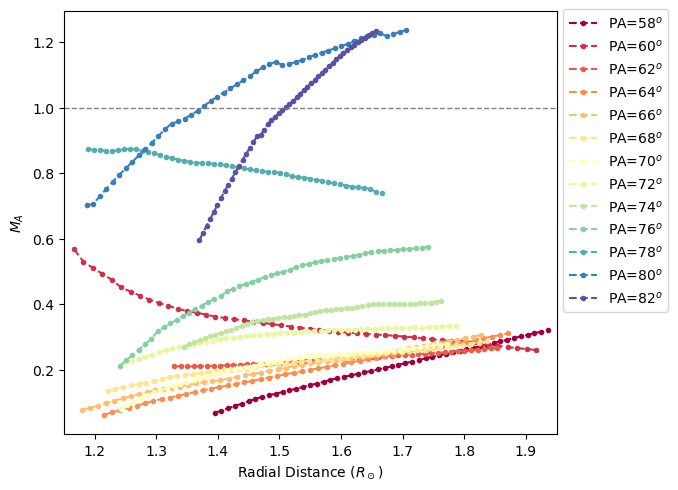

In [584]:
# all in one plot
fig = plt.figure(figsize=[7,5])
ax  = fig.add_subplot(111)

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(centered_list)
colors_list    = cmap(np.linspace(0, 1, num_lines))

common_distances = []
mach_numers      = []

for i in range(num_lines):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    
    # Get x and y from your data
    x = dist_SUVI_Rs[i]
    y = speeds_SUVI[i]
    
    # convert the VA distance from arcsec to Rsun
    dist_va = dist_VA_Rs[i]
    va_vals = smoothed_VA[i]
    
    # Define the common distances based on x's range
    common_dist = np.linspace(x.min(), x.max(), num=50)
    # Interpolation functions (bounded, no extrapolation)
    va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
    vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    # Interpolate
    va_interp   = va_interp_func(common_dist)
    vcme_interp = vcme_interp_func(common_dist)
    
    # Calculate Mach number (avoid divide-by-zero or NaNs)
    with np.errstate(divide='ignore', invalid='ignore'):
        mach_number = vcme_interp / va_interp
        mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)
    
    ax.plot(common_dist, mach_number, 'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')
    mach_numers.append(mach_number)
    common_distances.append(common_dist)

ax.axhline(y=1, color='Grey', ls='--', lw=1)
ax.set_xlabel(r'Radial Distance ($R_\odot$)')
ax.set_ylabel(r'$M_A$')
ax.grid(False)
ax.legend(loc='upper right', bbox_to_anchor=[1.24,1.02])
ax.set_xlim(left=1.15, right=1.95)
fig.tight_layout()
plt.show()

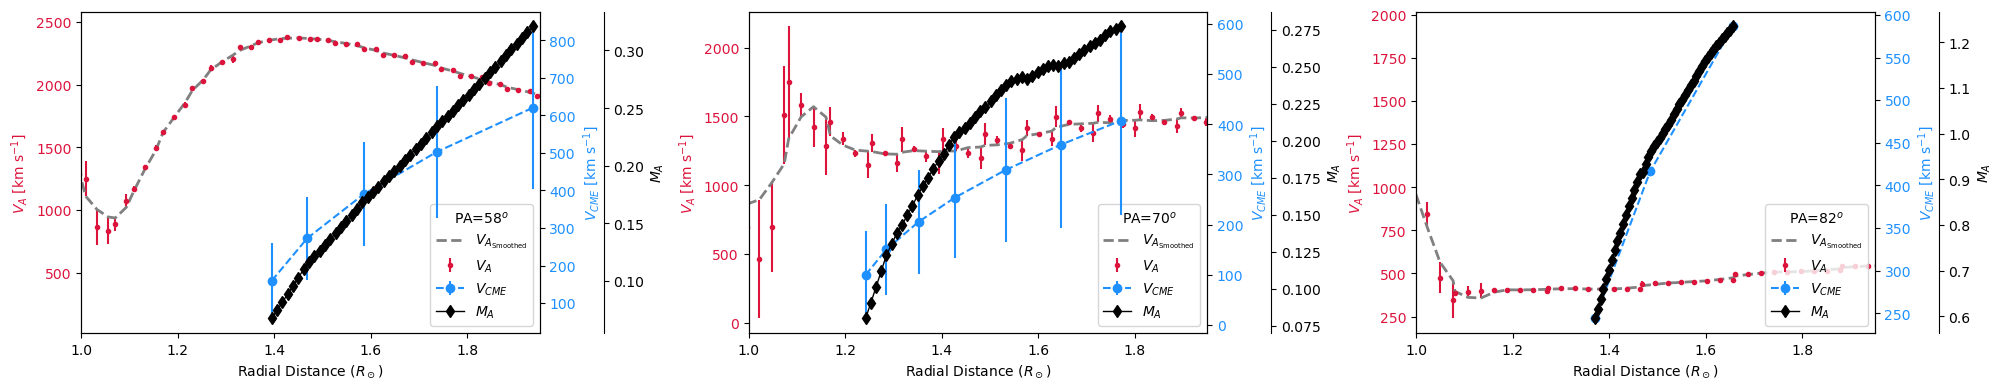

In [633]:
def make_patch_spines_invisible(ax):
    """Turn off everything except the spine you want."""
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)



fig = plt.figure(figsize=[20,4])
fig.subplots_adjust(right=0.75)          # make room on the right

slits_indices = [0, 6, -1]

for i, j in zip(slits_indices, range(1,4)):
    ax = fig.add_subplot(1, 3, j)
    
    PA_value = centered_list[i] - 90
    
    # --- 1) VA on the “host” axes ---
    dist_Rs = np.array(sampled_dist[i]) / va.rsun_obs.value
    y_va    = np.array(sampled_va[i])
    
    window_length = min(len(y_va) if len(y_va)%2 else len(y_va)-1, 11)
    polyorder     = 2 if window_length > 2 else 1
    y_va_smooth   = savgol_filter(y_va, window_length, polyorder)
    y_err         = np.abs(y_va - y_va_smooth)
    
    ax.errorbar(dist_Rs, y_va, yerr=y_err, fmt='o', ms=3, color='crimson', label=r'$V_A$')
    ax.plot(dist_Rs, y_va_smooth, '--', lw=2, color='gray', label=r'$V_{A_{\mathrm{Smoothed}}}$')
    
    ax.set_xlabel(r'Radial Distance ($R_\odot$)')
    ax.set_ylabel(r'$V_A$ [km s$^{-1}$]', color='crimson')
    ax.tick_params(axis='y', labelcolor='crimson')
    ax.set_xlim(1, 1.95)
    
    # --- 2) V_CME on the first twin ---
    ax2  = ax.twinx()
    x2   = all_fit_dist_Mm_suvi[i] * u.Mm.to('solRad')
    y2   = all_speeds_km_s_suvi[i]
    err2 = all_speed_errors[i]
    
    ax2.errorbar(x2, y2, yerr=err2, fmt='--o', color='dodgerblue', label=r'$V_{CME}$')
    ax2.set_ylabel(r'$V_{CME}$ [km s$^{-1}$]', color='dodgerblue')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')
    
    # --- 3) M_A on the second twin, offset its spine ---
    ax3 = ax.twinx()
    make_patch_spines_invisible(ax3)                 # start with a clean slate
    ax3.spines['right'].set_visible(True)            # show only the right spine
    ax3.spines['right'].set_position(('axes', 1.14)) # shift it 20% further right
    
    x3 = common_distances[i]
    y3 = mach_numers[i]
    ax3.plot(x3, y3, '-d', color='k', lw=1, label=r'$M_A$')
    ax3.set_ylabel(r'$M_A$', color='k')
    ax3.tick_params(axis='y', labelcolor='k')
    
    # finally, a single legend combining all three
    lines, labels = [], []
    for a in (ax, ax2, ax3):
        lns, labs = a.get_legend_handles_labels()
        lines += lns
        labels += labs
    ax.legend(lines, labels, loc='lower right', title=rf'PA={int(PA_value)}$^o$')

fig.tight_layout()
fig.savefig(f'{data_dir}/Vcme_Va_Ma.pdf', format='pdf', bbox_inches='tight')
plt.show()

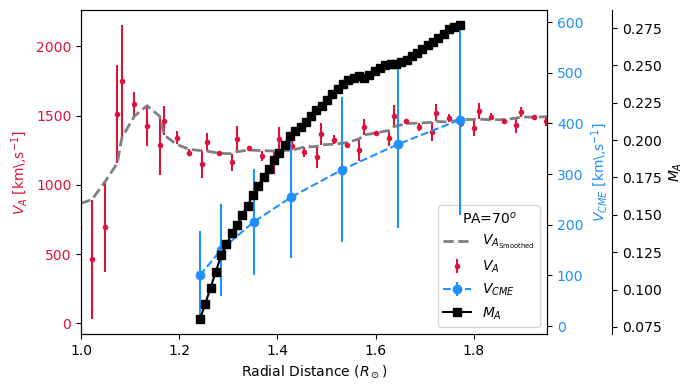

In [628]:
def make_patch_spines_invisible(ax):
    """Turn off everything except the spine you want."""
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax = plt.subplots(figsize=[7,4])
fig.subplots_adjust(right=0.75)          # make room on the right

i = 6
PA_value = centered_list[i] - 90

# --- 1) VA on the “host” axes ---
dist_Rs = np.array(sampled_dist[i]) / va.rsun_obs.value
y_va    = np.array(sampled_va[i])

window_length = min(len(y_va) if len(y_va)%2 else len(y_va)-1, 11)
polyorder     = 2 if window_length > 2 else 1
y_va_smooth   = savgol_filter(y_va, window_length, polyorder)
y_err         = np.abs(y_va - y_va_smooth)

ax.errorbar(dist_Rs, y_va, yerr=y_err, fmt='o', ms=3, color='crimson', label=r'$V_A$')
ax.plot(dist_Rs, y_va_smooth, '--', lw=2, color='gray', label=r'$V_{A_{\mathrm{Smoothed}}}$')

ax.set_xlabel(r'Radial Distance ($R_\odot$)')
ax.set_ylabel(r'$V_A$ [km\,s$^{-1}$]', color='crimson')
ax.tick_params(axis='y', labelcolor='crimson')
ax.set_xlim(1, 1.95)

# --- 2) V_CME on the first twin ---
ax2  = ax.twinx()
x2   = all_fit_dist_Mm_suvi[i] * u.Mm.to('solRad')
y2   = all_speeds_km_s_suvi[i]
err2 = all_speed_errors[i]

ax2.errorbar(x2, y2, yerr=err2, fmt='--o', color='dodgerblue', label=r'$V_{CME}$')
ax2.set_ylabel(r'$V_{CME}$ [km\,s$^{-1}$]', color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

# --- 3) M_A on the second twin, offset its spine ---
ax3 = ax.twinx()
make_patch_spines_invisible(ax3)                # start with a clean slate
ax3.spines['right'].set_visible(True)           # show only the right spine
ax3.spines['right'].set_position(('axes', 1.14)) # shift it 20% further right

x3 = common_distances[i]
y3 = mach_numers[i]
ax3.plot(x3, y3, '-s', color='k', label=r'$M_A$')
ax3.set_ylabel(r'$M_A$', color='k')
ax3.tick_params(axis='y', labelcolor='k')

# finally, a single legend combining all three
lines, labels = [], []
for a in (ax, ax2, ax3):
    lns, labs = a.get_legend_handles_labels()
    lines += lns
    labels += labs
ax.legend(lines, labels, loc='lower right', title=rf'PA={int(PA_value)}$^o$')

plt.tight_layout()
plt.show()